In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error


In [2]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
close_prices = data['Close']
train_size = int(len(close_prices) * 0.7)
test_size = int(len(close_prices) * 0.2)
validation_size = len(close_prices) - train_size - test_size

window_size = 60
train_data = close_prices.iloc[:train_size]
test_data = close_prices.iloc[train_size - window_size:train_size+test_size]
validation_data = close_prices.iloc[train_size+test_size-window_size:]

In [3]:
# Define sliding window function
def sliding_window(data, window_size):
  X = []
  y = []
  for i in range(len(data) - window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])
  return np.array(X), np.array(y)

In [4]:
# Create sliding windows for train data
x_train, y_train = sliding_window(train_data.values, window_size)

In [5]:
# Define model
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, tau=1.0/100)
    beta = pm.Normal('beta', mu=0, tau=1.0/100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)

    # Likelihood
    mu = alpha + beta * x_train.mean()
    y_obs = pm.Normal('y_obs', mu=mu, tau=1.0/sigma**2, observed=y_train)

    # Inference
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

In [6]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

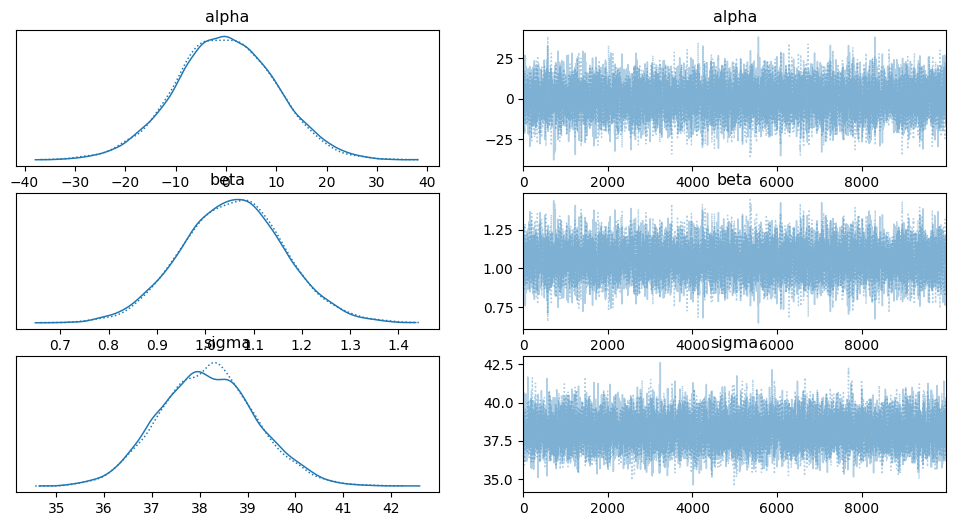

In [7]:
import arviz as az
az.plot_trace(trace)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

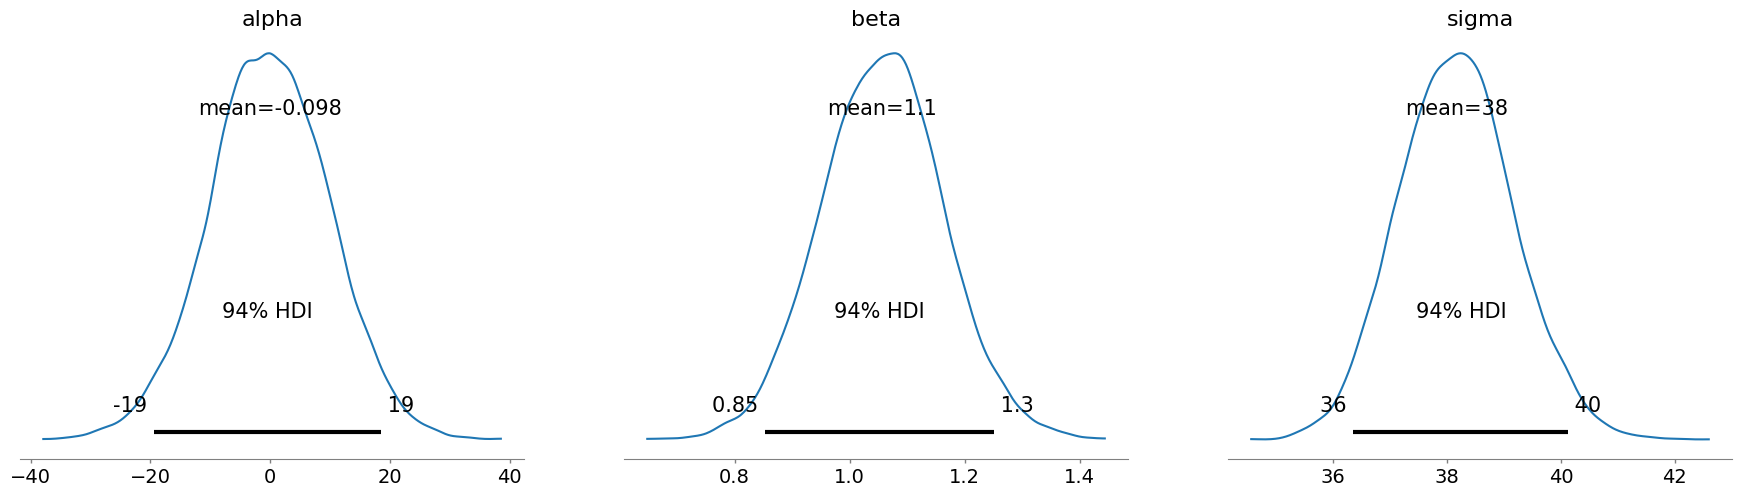

In [8]:
az.plot_posterior(trace)

In [9]:
# Define sliding windows for test data
x_test, y_test = sliding_window(test_data.values, window_size)

# Predict on test data
alpha_post = trace.posterior["alpha"].mean().values
beta_post = trace.posterior["beta"].mean().values

# Tính giá trị dự đoán trên tập test
stock_test_pred = []
for i in range(len(x_test)):
  pred = alpha_post + beta_post * x_test[i].mean()
  stock_test_pred.append(pred)

In [10]:
rmse_test = np.sqrt(mean_squared_error(test_data.values[window_size:], stock_test_pred))
print(f'RMSE Bayesian Linear Regression on Test Data: {rmse_test}')

RMSE Bayesian Linear Regression on Test Data: 16.955542526700366


In [11]:
len(test_data)

277

In [12]:
# Define sliding windows for validation data
x_validation, y_validation = sliding_window(validation_data.values, window_size)

# Make predictions on validation data
stock_validation_pred = []
for i in range(len(x_validation)):
  pred = alpha_post + beta_post * x_validation[i].mean()
  stock_validation_pred.append(pred)

In [13]:
rmse_validation = np.sqrt(mean_squared_error(validation_data.values[window_size:], stock_validation_pred))
print(f'RMSE Bayesian Linear Regression on Validation Data: {rmse_validation}')

RMSE Bayesian Linear Regression on Validation Data: 10.738610199757703


<ipython-input-14-49cdac4f6194>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = stock_test_pred
<ipython-input-14-49cdac4f6194>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = stock_validation_pred


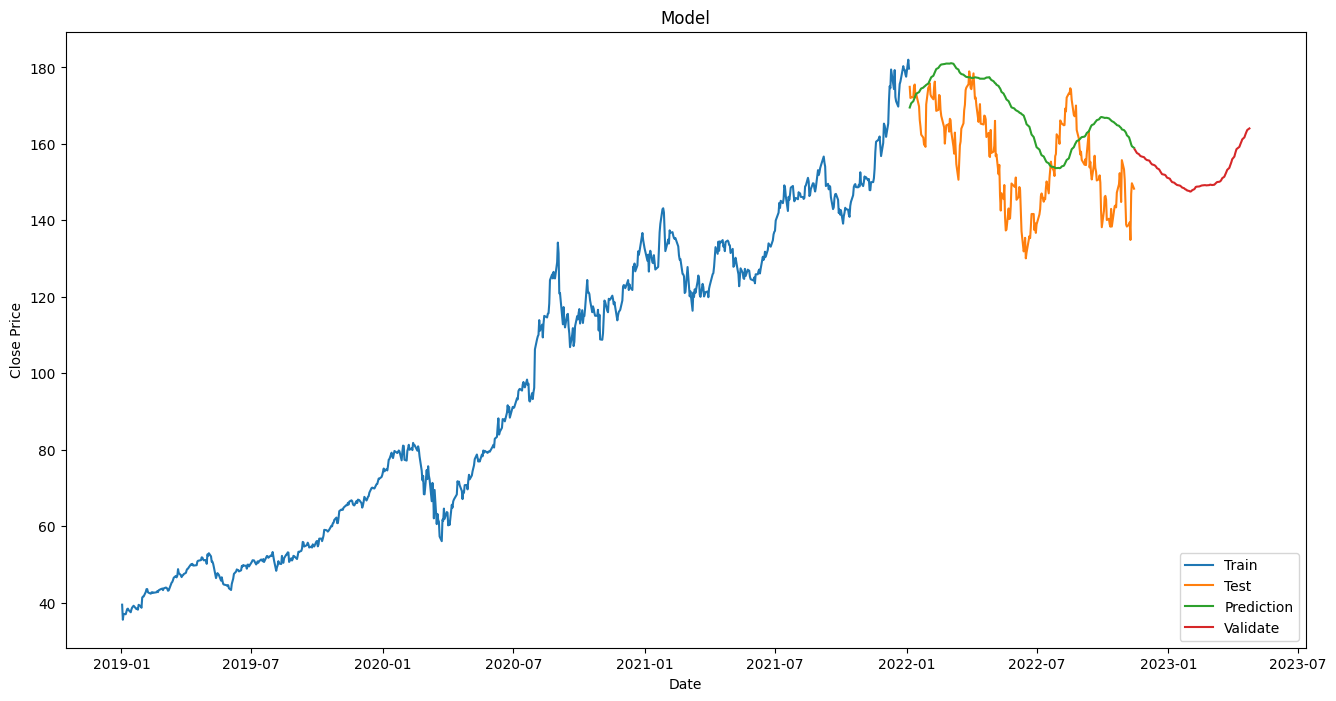

In [14]:
import matplotlib.pyplot as plt
data = data.filter(['Close'])
train = data[:train_size]
test = data[train_size:train_size+test_size]
validation = data[train_size+test_size:]
test['Predictions'] = stock_test_pred
validation['Predictions'] = stock_validation_pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(test[['Close', 'Predictions']])
plt.plot(validation['Predictions'])
plt.legend(['Train', 'Test', 'Prediction','Validate'], loc='lower right')
plt.show()

In [15]:
# Use a rolling window approach with window size = 5
num_predictions = 30

stock_pred = np.zeros(num_predictions)
last_data = validation_data[-window_size:].values

for i in range(num_predictions):
    mu = alpha_post + beta_post * last_data.mean()
    stock_pred[i] = mu
    last_data = np.append(last_data[1:], mu)

print(f'Bayesian Linear Regression Predictions for Next {num_predictions} Days: \n{stock_pred}')

Bayesian Linear Regression Predictions for Next 30 Days: 
[164.41635691 164.74211164 165.12523705 165.49238223 165.84590866
 166.11068537 166.31528134 166.57229379 166.78238084 167.04427612
 167.32928883 167.61685686 167.85944739 168.11776673 168.34310444
 168.6009594  168.88379896 169.24334156 169.60164247 169.95762283
 170.36727726 170.76282868 171.17433703 171.63010166 172.08332456
 172.45431263 172.78249817 173.15576233 173.51322498 173.91716328]


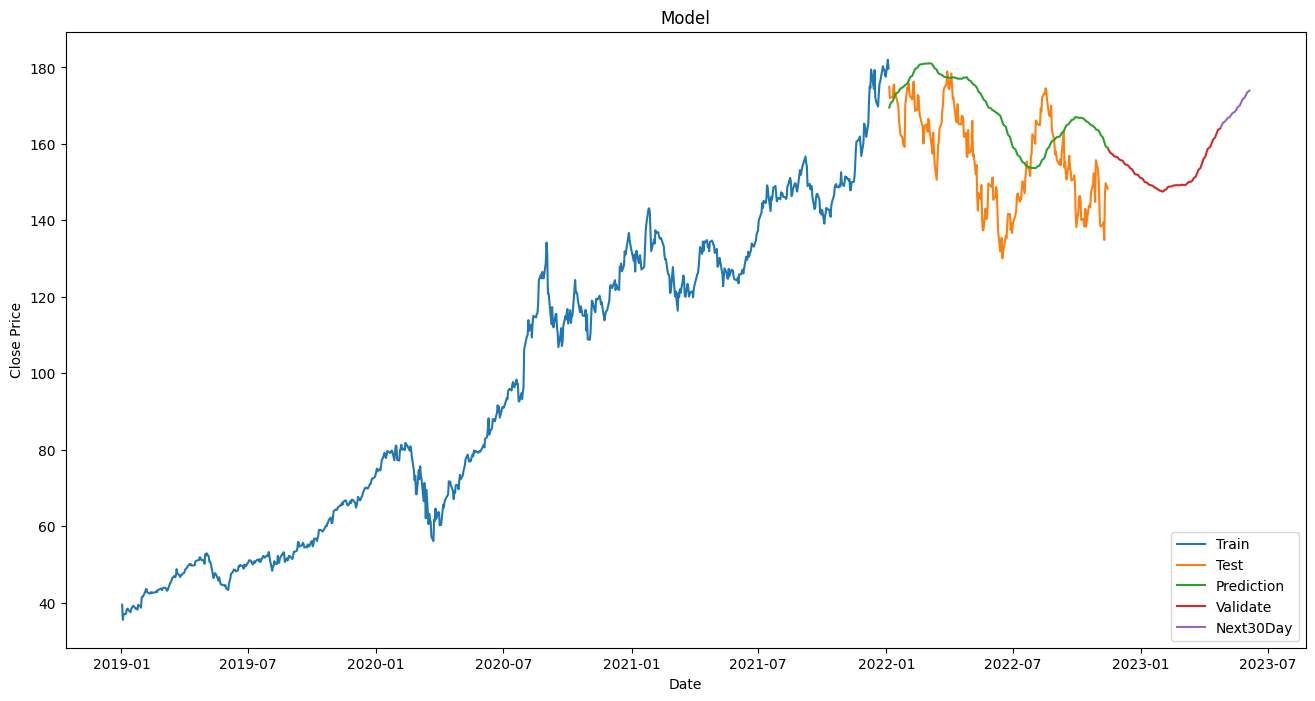

In [16]:
num_predictions = 30
future_dates = pd.date_range(start=validation.index[-1], periods=num_predictions+1, freq='B')[1:]
future_pred_df = pd.DataFrame({'Date': future_dates, 'Predictions': stock_pred})
future_pred_df.set_index('Date', inplace=True)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(test[['Close', 'Predictions']])
plt.plot(validation['Predictions'])
plt.plot(future_pred_df)
plt.legend(['Train', 'Test', 'Prediction', 'Validate', 'Next30Day'], loc='lower right')
plt.show()


In [17]:
# import plotly package for graphs
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

x_train_ind = list(range(0, train_size))
x_test_ind = list(range(train_size, train_size+test_size))
x_validation_ind = list(range(train_size+test_size, len(data)))
x_pred_ind = list(range(len(data), len(data)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train_ind, y=train['Close'], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=x_test_ind,y=test['Close'], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=x_test_ind,y=test['Predictions'], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=x_validation_ind, y=validation['Predictions'], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=x_pred_ind, y=future_pred_df['Predictions'], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#9569BE'))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'AAPL MCMC data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()